In [60]:
import numpy as np  
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import os
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats
import sep
from reproject import reproject_interp
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.stats import sigma_clip

In [61]:
import warnings
from astropy.wcs import FITSFixedWarning
warnings.simplefilter('ignore', category=FITSFixedWarning)

### Factor F

In [62]:
GAIAspectrum = fits.open('GAIA3_509862066010920960.fits')

def Factor(filtro):

    file_name = f"{filtro}_trasmission.txt"

    r_trasm = Table.read(file_name, format='ascii.basic')
    r_wave=r_trasm["Wavelength(A)"]
    r_value=r_trasm["Transmission(QE*Filter)"]

    r_trasm_new=np.interp(GAIAspectrum[1].data, r_wave, r_value)

    x=GAIAspectrum[1].data
    y_filter=r_trasm_new
    y_spectrum=np.array(GAIAspectrum[0].data)

    Num = np.trapz(y_spectrum * y_filter, x)
    Den= np.trapz(y_filter, x)
    return Num/Den           # Factor for the flux

### Bias 
Independent on anything 


In [ ]:
def bias():
    Grid=[]
    path=os.getcwd()+'/bias'
    for file in os.listdir(path):
        fitsfile=fits.open(path+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)
    return np.mean(Grid, axis=0)

# it is the same for all the images 
#masterbias=bias()

### Flat

In [64]:
def flat(filtro):   
    pathf=os.getcwd()+f"/{filtro}FLAT"
    
    Grid=[]
    for file in os.listdir(pathf):
        fitsfile=fits.open(pathf+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)
    master=np.median(Grid, axis=0)-bias()
    
    return master/np.median(master)

#masterflat=flat('R')
#print(masterflat)

### Dark current

In [65]:
def dark_current(exptime):

    pathd=os.getcwd()+'/DARK'+f'{exptime}'
    Grid=[]
    for file in os.listdir(pathd):
        fitsfile=fits.open(pathd+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)

    master=np.median(Grid, axis=0)-bias()
    return master

#mastercurrent=dark_current('300')

In [66]:
def background(data2, pixpos):

    pixpos_x=int(pixpos[0])
    pixpos_y=int(pixpos[1])

    data_cut = data2[pixpos_y-50:pixpos_y+50,pixpos_x-50:pixpos_x+50]
    position = [50, 50]     #in the center 

    ap = CircularAperture(position, r=15)
    photo_inside = aperture_photometry(data_cut,ap)
    final_flux = photo_inside[0][3:]

    annulus_ap=CircularAnnulus(position, r_in=20, r_out=30)
    aperstats= ApertureStats(data_cut, annulus_ap)
    bkg_mean=aperstats.mean

    aperture_area=ap.area
    total_bkg=bkg_mean*aperture_area
    
    return final_flux - total_bkg


In [67]:
c = SkyCoord('01:33:12 +60:42:00', unit=(u.hourangle, u.deg))

ref_wcs =  WCS(naxis=2)

ref_wcs.wcs.crval =[c.ra.degree, c.dec.degree]
ref_wcs.wcs.crpix =[4000/2.0, 4000/2.0]  
ref_wcs.wcs.ctype =["RA---TAN", "DEC--TAN"] 
ref_wcs.wcs.cunit=["deg", "deg"]

#trasformation of 0.55 arcsec/pixel
dim_degrees= (0.55/3600.0)

ref_wcs.wcs.cd= np.array([[-dim_degrees, 0.0], [0.0, dim_degrees]])

In [85]:
def DataProcess(filtro, exptime):

    Path = os.path.join(os.getcwd(), 'DATA', filtro)
    masterbias=bias()
    mastercurrent=dark_current(exptime)
    masterflat=flat(filtro)

    all_images=[]
    Calibrations=[]

    for file in os.listdir(Path):       #for all the file in the filter of a given day

        if not file.lower().endswith('.fits'):
            continue

        Fitsfile=fits.open(Path+'/'+file)

        #read the data 
        Data = Fitsfile[0].data

        #coordinates of the image
        wcs = WCS(Fitsfile[0].header)
        pixpos = wcs.wcs_world2pix(23.38804096055661,60.63702187961969, 1)         #coordinates of the star for calibration

        data1 = (Data-masterbias-mastercurrent)/masterflat
        
        data2=data1*0.25/exptime                                    # to have the flux in e-/s     
        
        Calibration_costant=Factor(filtro)/background(data2, pixpos) #calibartion costant and 10**16 preventing numerical error 
        Calibrations.append(Calibration_costant)

        data3=data2*Calibration_costant*10**16                 #calibartion costant and 10**16 preventing numerical error 
        data=data3-np.median(data3)
        std=np.std(data3)
        objects, map = sep.extract(data, 1.5, err=std, segmentation_map=True)              #return an image 


        bkg = sep.Background(data, mask=map, bw=64, bh=64, fw=12, fh=12)
        Final=data3-bkg

        #reproject the image 
        new_repr= reproject_interp((Final, wcs), ref_wcs, shape_out=(4000,4000))
        all_images.append(new_repr[0])
        #print(new_repr[0])

        #plt.imshow(new_repr[0], vmin=mean_f-2*std_f,vmax=mean_f+2*std_f,cmap='gray', origin='lower')
        #plt.show()
        #print("ok")

    return np.median(all_images, axis=0), np.median(Calibrations, axis=0)       #choose the correct axis 

In [86]:
Result, Cal = DataProcess('R',300)

In [87]:
Result_mean = np.nanmedian(Result)  # ignora i NaN
Result_std  = np.nanstd(Result)   # ignora i NaN

print(Result_mean)
print(Result_std)
print(Cal)

6.433361125675129
0.4259140843432646
[7.269174e-17]


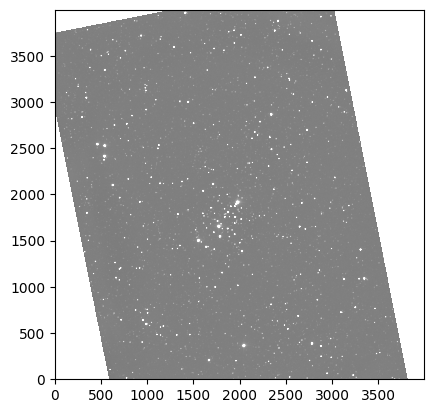

In [88]:
plt.imshow(Result, vmin=Result_mean-2*Result_std, vmax=Result_mean+2*Result_std, cmap='gray', origin='lower')

Errors with Sigma_Clipping

In [120]:
histo=Result.flatten()
backs=sigma_clip(histo, sigma=3, maxiters=5)
sigma_back=np.std(backs)

def flux_and_errors(Result, pixpos_x, pixpos_y, Cal, exptime, maps_i):

    pixpos_x=int(pixpos_x)
    pixpos_y=int(pixpos_y)

    Result=Result*maps_i
    data_cut = Result[pixpos_y-50:pixpos_y+50,pixpos_x-50:pixpos_x+50]
    position = [50, 50]     #in the center 

    ap = CircularAperture(position, r=15)
    photo_inside = aperture_photometry(data_cut,ap)
    S = photo_inside[0][3]          #flux inside the aperture
    n_pixels=np.pi*15**2            #area in pixel
    #n_pixels=ap.area

    sigma_b=sigma_back*np.sqrt(n_pixels)
    sigma_f=np.sqrt(Cal*10**16/exptime*S)         #10**16!!!
    E=np.sqrt(sigma_f**2 + sigma_b**2)

    return S, E


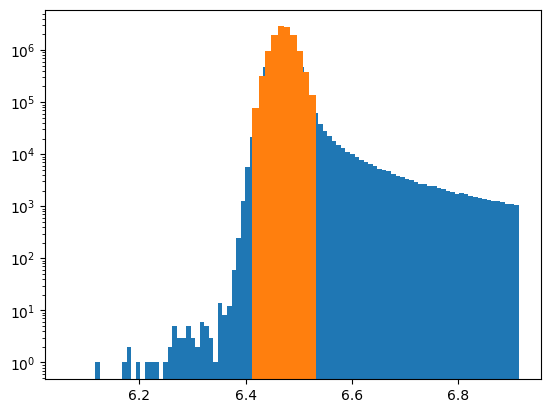

In [ ]:
histo=Result.flatten()
bins=np.linspace(Result_mean-Result_std, Result_mean+Result_std, 100)
plt.hist(Result.flatten(), bins=bins)

backs=sigma_clip(histo, sigma=3, maxiters=5)
plt.hist(backs)
plt.yscale('log')

In [121]:
std=np.nanstd(Result)
objects, map = sep.extract(Result-np.nanmedian(Result), 1.5, err=std, segmentation_map=True)
#object gives already the positions
x_star=(objects["xmax"]+objects["xmin"])/2
y_star=(objects["ymax"]+objects["ymin"])/2

In [ ]:
Flux_star = []
Error = [] 
for i in range(0,len(x_star)):
    maps_i=map/(i+1)
    maps_i[maps_i!=1]=0
    flux, error=flux_and_errors(Result, x_star[i], y_star[i], Cal, 300, maps_i)
    Flux_star.append(flux)
    Error.append(error)

### the first are nan beacuse they are close to the edges of the images

the we have to convert in magnitude, from flux per armstrong to flux per frequency

In [131]:
print(Flux_star)
print(Error)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 244.5199811519169, 228.38779471633495, 659.3882353619501, 220.8798660827161, 41.20786929040759, 84.80663387784557, 442.43672737899345, 40.22466510864781, 74.40201020742944, 215.24680739649972, 93.48324603239908, 35.47006544597835, 316.64003212372296, 35.82384182876304, 210.20669965144066, 89.5284640246782, 62.34816648356609, 341.06079242513135, 172.03477434327758, nan, 594.7958993245254, 39.42382229151481, 555.8105742840844, 572.8160788723122, 56.69892671657368, 4205.182890913056, 196.5705860390763, 143.56295403271528, 141.49698324396923, 650.7406246872051, 294.20912887380047, 142.85528766860193, 443.9575567193625, 761.6997824134148, 117.70392078203662, 34.5434077224457, 151.43309840089432, 196.40222746149652, 41.768658084264445, 690.1177794687226, 262.1363249981366, 150.31468500713493, 362.85334169377313, 65.05555827419845, 297.65204044584436, 52.354186429286166, 59.335581161935814, 307.3929236131497, 256.77891538677136

### An other filter

In [130]:
#run other filter 
Result2, Cal2 = DataProcess('G',300)

In [134]:
Result_mean2 = np.nanmean(Result2)  
Result_std2  = np.nanstd(Result2)   

std2=np.nanstd(Result2)
objects, map = sep.extract(Result2-np.nanmedian(Result2), 1.5, err=std2, segmentation_map=True)
#object gives already the positions
x_star=(objects["xmax"]+objects["xmin"])/2
y_star=(objects["ymax"]+objects["ymin"])/2

Flux_star = []
Error = [] 
for i in range(0,len(x_star)):
    maps_i=map/(i+1)
    maps_i[maps_i!=1]=0
    flux, error=flux_and_errors(Result2, x_star[i], y_star[i], Cal2, 300, maps_i)
    Flux_star.append(flux)
    Error.append(error)

In [135]:
print(Flux_star)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 314.5825643460089, 264.63868818047854, 661.8571892020366, 211.9321788392151, 48.62086083761439, 106.54538444469372, 481.31687372756164, 48.320869447524366, 81.39982640756205, 247.16413723582085, 114.78747548242845, 40.388338086608, 411.8613078167448, 40.51937342587992, 265.7024076840007, 106.3001571012069, 73.5026886327953, 424.8541892646377, 202.1893217845609, 317.58181009946804, 751.3666250878282, 40.47510037828939, 535.3993254143825, 715.2472861631102, 56.619445120015484, 4975.882414853191, 228.85677311037944, 148.5106451472102, 175.90306101861825, 723.4006660859452, 344.09780489850925, 158.5604236865023, 555.3250961331726, 1047.026739771136, 149.15439536881922, 40.59619670169839, 192.21377935916772, 244.741006001185, 48.606741637192194, 987.723991361416, 286.7681980470218, 166.50834632054472, 454.94706603112456, 73.83672195190732, 306.79007735594575, 64.49885317567245, 73.3070560066288, 352.9619188113099, 295.3692631